# Sklearn

## Bike Sharing Demand
Competition on kaggle: https://www.kaggle.com/c/bike-sharing-demand

In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

You've got 11 Data Fields: https://www.kaggle.com/c/prudential-life-insurance-assessment/data


### Libs

In [0]:
import scipy
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import linear_model, metrics

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Data

In [0]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/OzmundSedler/100-Days-Of-ML-Code/master/week%201/datasets/bike_sharing_demand.csv', header = 0, sep = ',')

In [0]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***casual*** - number of non-registered user rentals initiated

***registered*** - number of registered user rentals initiated

***count*** - number of total rentals

In [0]:
print (raw_data.shape)

(10886, 12)


In [0]:
raw_data.isnull().values.any()

False

###  Data preprocessing

#### Features types

In [0]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [0]:
raw_data.datetime = raw_data.datetime.apply(pd.to_datetime)

In [0]:
raw_data['month'] = raw_data.datetime.apply(lambda x : x.month)
raw_data['hour'] = raw_data.datetime.apply(lambda x : x.hour)

In [0]:
raw_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4


#### Train and hold out test

In [0]:
train_data = raw_data.iloc[:-1000, :]
hold_out_test_data = raw_data.iloc[-1000:, :]

In [0]:
print (raw_data.shape, train_data.shape, hold_out_test_data.shape)

(10886, 14) (9886, 14) (1000, 14)


In [0]:
print ('train period from {} to {}'.format(train_data.datetime.min(), train_data.datetime.max()))
print ('evaluation period from {} to {}'.format(hold_out_test_data.datetime.min(), hold_out_test_data.datetime.max()))

train period from 2011-01-01 00:00:00 to 2012-10-16 06:00:00
evaluation period from 2012-10-16 07:00:00 to 2012-12-19 23:00:00


#### Drop data column

In [0]:
train_labels = train_data['count'].values
train_data = train_data.drop(['datetime', 'count'], axis = 1)

In [0]:
test_labels = hold_out_test_data['count'].values
test_data = hold_out_test_data.drop(['datetime', 'count'], axis = 1)

#### Train and test data

Text(0.5, 1.0, 'test data')

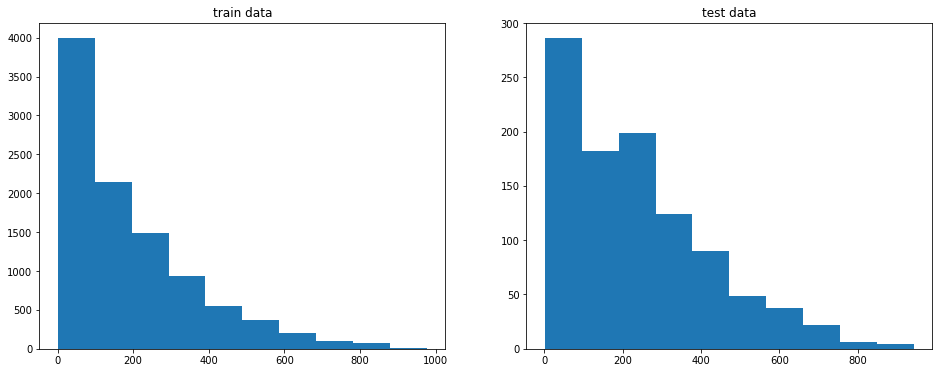

In [0]:
pylab.figure(figsize = (16, 6))

pylab.subplot(1,2,1)
pylab.hist(train_labels)
pylab.title('train data')

pylab.subplot(1,2,2)
pylab.hist(test_labels)
pylab.title('test data')

#### Numeric features

In [0]:
numeric_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'month', 'hour']

In [0]:
train_data = train_data[numeric_columns]
test_data = test_data[numeric_columns]

In [0]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


In [0]:
test_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
9886,17.22,21.210,67,6.0032,20,505,10,7
9887,18.04,21.970,62,0.0000,35,800,10,8
9888,19.68,23.485,55,16.9979,32,323,10,9
9889,20.50,24.240,48,19.0012,65,157,10,10
9890,20.50,24.240,45,27.9993,56,172,10,11


### Bad model

In [0]:
regressor = linear_model.SGDRegressor(random_state = 0)

In [0]:
regressor.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(test_data))

20997892275395.24

In [0]:
print (test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [0]:
print (regressor.predict(test_data)[:10])

[-4.99986663e+13 -7.97284299e+13 -3.21995211e+13 -1.77617542e+13
 -1.82305753e+13 -2.73783598e+13 -2.78284282e+13 -2.48444248e+13
 -2.90120004e+13 -3.87194278e+13]


In [0]:
regressor.coef_

array([ 3.20441588e+10,  2.19976988e+10, -1.17558255e+10,  4.54473983e+10,
       -5.88168551e+10, -9.72645501e+10, -3.64527186e+10,  1.65877622e+10])

That's why we need feature scaling

### Scaling

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
scaler = StandardScaler()
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [0]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

0.04293048301240903

In [0]:
print (test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [0]:
print (regressor.predict(scaled_test_data)[:10])

[524.90958201 834.88816062 354.94091402 221.96933203 227.95283001
 324.96044934 327.966113   307.98463956 345.96942383 445.96231877]


Now it's too good to be true

### Why?

In [0]:
print (regressor.coef_)

[ 4.58902678e-01 -4.51836158e-01  6.62608792e-04 -1.40703258e-02
  5.08590377e+01  1.48008168e+02 -1.32281341e-03  7.59230341e-03]


In [0]:
print (map(lambda x : round(x, 2), regressor.coef_))

In [0]:
train_data.head()

,temp,atemp,humidity,windspeed,casual,registered,month,hour
0,9.84,14.395,81,0.0,3,13,1,0
1,9.02,13.635,80,0.0,8,32,1,1
2,9.02,13.635,80,0.0,5,27,1,2
3,9.84,14.395,75,0.0,3,10,1,3
4,9.84,14.395,75,0.0,0,1,1,4


In [0]:
train_labels[:10]

array([16, 40, 32, 13,  1,  1,  2,  3,  8, 14])

In [0]:
np.all(train_data.registered + train_data.casual == train_labels)

True

That's the problem - we found features that 100% correct predicts our function. Let's drop them and move forward.

In [0]:
train_data.drop(['casual', 'registered'], axis = 1, inplace = True)
test_data.drop(['casual', 'registered'], axis = 1, inplace = True)

In [0]:
scaler.fit(train_data, train_labels)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [0]:
regressor.fit(scaled_train_data, train_labels)
metrics.mean_absolute_error(test_labels, regressor.predict(scaled_test_data))

121.8835371361759

In [0]:
print (map(lambda x : round(x, 2), regressor.coef_))

Now we are ready to go!

### Pipeline

In [0]:
from sklearn.pipeline import Pipeline

Adding scaling for every step. 

In [0]:
pipeline = Pipeline(steps = [('scaling', scaler), ('regression', regressor)])

In [0]:
pipeline.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, pipeline.predict(test_data))

121.8835371361759

### Best params search

In [0]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaling', 'regression', 'scaling__copy', 'scaling__with_mean', 'scaling__with_std', 'regression__alpha', 'regression__average', 'regression__early_stopping', 'regression__epsilon', 'regression__eta0', 'regression__fit_intercept', 'regression__l1_ratio', 'regression__learning_rate', 'regression__loss', 'regression__max_iter', 'regression__n_iter_no_change', 'regression__penalty', 'regression__power_t', 'regression__random_state', 'regression__shuffle', 'regression__tol', 'regression__validation_fraction', 'regression__verbose', 'regression__warm_start'])

In [0]:
parameters_grid = {
    'regression__loss' : ['huber', 'epsilon_insensitive', 'squared_loss', ],
    'regression__max_iter' : [3, 5, 10, 50], 
    'regression__penalty' : ['l1', 'l2', 'none'],
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

In [0]:
grid_cv = GridSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_absolute_error', cv = 4)

In [0]:
%%time
grid_cv.fit(train_data, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linea

CPU times: user 19.6 s, sys: 14 s, total: 33.6 s
Wall time: 17.2 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1187: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaling',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('regression',
                                        SGDRegressor(alpha=0.0001,
                                                     average=False,
                                                     early_stopping=False,
                                                     epsilon=0.1, eta0=0.01,
                                                     fit_intercept=True,
                                                     l1_ratio=0.15,
                                                     learning_rate='invscaling',
                                                     loss='squared_loss',
                      

In [0]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

-108.61772632999148
{'regression__alpha': 0.01, 'regression__loss': 'squared_loss', 'regression__max_iter': 3, 'regression__penalty': 'l2', 'scaling__with_mean': 0.0}


### Predictions on test data

In [0]:
metrics.mean_absolute_error(test_labels, grid_cv.best_estimator_.predict(test_data))

119.98978845935379

In [0]:
np.mean(test_labels)

232.159

In [0]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

In [0]:
print (test_labels[:10])

[525 835 355 222 228 325 328 308 346 446]


In [0]:
print (test_predictions[:10])

[139.60470681 159.80765341 207.55935972 237.76288054 257.83836668
 267.44558034 272.49537469 297.70688522 304.29818873 313.58821156]


(-100, 1100)

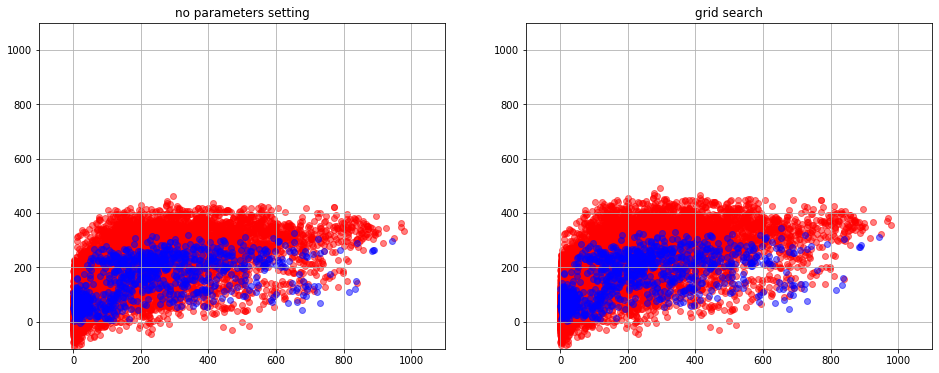

In [0]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(train_labels, pipeline.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, pipeline.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('no parameters setting')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('grid search')
pylab.xlim(-100,1100)
pylab.ylim(-100,1100)

As we see, the model is not good enough. We will work further on it in the next lesson.